# 深度置信网络的MNIST手写识别

In [7]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# 设置超参数
batch_size = 64
learning_rate = 0.001

# 记录训练过程中的损失值用以可视化
loss_values = []

In [ ]:

# 加载 MNIST 数据集
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### transform为对数据集的预处理规则，包含两个操作：
1. `ToTensor()`将图像转换为 PyTorch 的 Tensor 数据类型。PyTorch 中的神经网络模型通常需要使用 Tensor 类型的数据进行训练，因此这个操作将图像转换为神经网络可接受的数据格式。
2. `Normalize()`对图像进行标准化处理，这里传入的参数是均值和标准差。对图像的每个通道执行标准化操作，这有助于加快模型的收敛速度，并提高模型的训练稳定性。

In [ ]:
# RBM 类的定义
class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(visible_units, hidden_units))     # 随机初始化所有权重
        self.v_bias = nn.Parameter(torch.randn(visible_units))              # 根据可见层数量初始化可见层偏置
        self.h_bias = nn.Parameter(torch.randn(hidden_units))               # 根据隐藏层数量初始化隐藏层偏置

    def forward(self, v):
        h_prob = torch.sigmoid(torch.matmul(v, self.W) + self.h_bias)
        h_sample = torch.bernoulli(h_prob)
        return h_sample                                                     # 返回隐藏层的采样值

- `v`: 表示可见层的输入。
- `self.W`: 是可训练的权重矩阵，连接可见层和隐藏层。
- `self.h_bias`: 表示隐藏层的偏置（隐藏层的阈值）。


1. `torch.matmul(v, self.W) + self.h_bias`: 这行代码计算了隐藏层单元的激活值。首先，它执行了可见层输入 `v` 与权重矩阵 `self.W` 的矩阵乘法，然后加上隐藏层的偏置 `self.h_bias`。
   
2. `torch.sigmoid(...)`: 对上一步计算的结果进行 Sigmoid 激活函数的处理，将激活值转换为介于 0 和 1 之间的概率值。这些值代表隐藏单元被激活的概率。

3. `torch.bernoulli(...)`: 将这些概率值作为伯努利分布的参数，进行伯努利采样，以确定每个隐藏单元是否被激活。即，以概率值为准，随机决定是否将隐藏单元置为1（激活）或0（不激活）。

4. `return h_sample`: 返回进行伯努利采样后的隐藏层的采样值。

这段代码实现了一个典型的受限玻尔兹曼机中可见层到隐藏层的前向传播过程，其中隐藏层的状态是通过 Sigmoid 激活函数和伯努利采样得到的。

In [8]:
# DBN 类的定义
# 由于MNIST为28像素*28像素的图片，故第一层RBM为[784*512]，第二层为[512*256]，第三层为[256*10]
class DeepBeliefNetwork(nn.Module):
    def __init__(self):
        super(DeepBeliefNetwork, self).__init__()
        self.rbm1 = RBM(visible_units=28 * 28, hidden_units=512)
        self.rbm2 = RBM(visible_units=512, hidden_units=256)
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)   # 重塑输入数据以匹配 rbm1 的输入维度
        x = self.rbm1(x)          # 第一个 RBM 的输出
        x = self.rbm2(x)          # 第二个 RBM 的输出
        x = self.fc(x)            # 全连接层
        return x

In [9]:
# 初始化模型、损失函数和优化器
model = DeepBeliefNetwork()
criterion = nn.CrossEntropyLoss()           # 使用交叉熵，适用于多分类问题
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# 训练模型
epochs = 50
for epoch in range(epochs):
    # 设置变量用于追踪每个epoch内每个batch的损失值总和，方便输出
    running_loss = 0.0
    
    # 利用Dataloader对训练集进行遍历
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data       # data返回值为一个包含输入数据与对应标签的二元组
        optimizer.zero_grad()       # 将模型参数的梯度归零，使其不会累积之前计算的梯度值
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()             # 反向传播
        optimizer.step()

        running_loss += loss.item()
        
        if i % 300 == 299:          # 每 300 次迭代打印一次损失值
            avg_loss = running_loss / 300
            loss_values.append(avg_loss)
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.4f}")
            running_loss = 0.0

print("Finished Training")

Epoch 1, Batch 300, Loss: 1.7205
Epoch 1, Batch 600, Loss: 1.5910
Epoch 1, Batch 900, Loss: 1.5544
Epoch 2, Batch 300, Loss: 1.5442
Epoch 2, Batch 600, Loss: 1.5373
Epoch 2, Batch 900, Loss: 1.5277
Epoch 3, Batch 300, Loss: 1.5233
Epoch 3, Batch 600, Loss: 1.5219
Epoch 3, Batch 900, Loss: 1.5225
Epoch 4, Batch 300, Loss: 1.5146
Epoch 4, Batch 600, Loss: 1.5173
Epoch 4, Batch 900, Loss: 1.5169
Epoch 5, Batch 300, Loss: 1.5118
Epoch 5, Batch 600, Loss: 1.5127
Epoch 5, Batch 900, Loss: 1.5094
Epoch 6, Batch 300, Loss: 1.5072
Epoch 6, Batch 600, Loss: 1.5100
Epoch 6, Batch 900, Loss: 1.5068
Epoch 7, Batch 300, Loss: 1.5121
Epoch 7, Batch 600, Loss: 1.5032
Epoch 7, Batch 900, Loss: 1.5044
Epoch 8, Batch 300, Loss: 1.5015
Epoch 8, Batch 600, Loss: 1.5032
Epoch 8, Batch 900, Loss: 1.5008
Epoch 9, Batch 300, Loss: 1.5013
Epoch 9, Batch 600, Loss: 1.5031
Epoch 9, Batch 900, Loss: 1.5036
Epoch 10, Batch 300, Loss: 1.5005
Epoch 10, Batch 600, Loss: 1.5010
Epoch 10, Batch 900, Loss: 1.5028
Epoch 1

在 PyTorch 中，梯度是在反向传播过程中计算的，用于更新神经网络的参数，优化模型以减小损失函数的值。然而，梯度是累积的，即每次计算梯度时，PyTorch 默认会将新计算得到的梯度值添加到已有的梯度上。

In [11]:
# 测试模型
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Accuracy on test set: 96.80%


在 PyTorch 中， `_, predicted = torch.max(outputs.data, 1)` 中，下划线 `_` 实际上是一个占位符，用于忽略 `torch.max()` 函数返回的第一个值，只保留第二个值。

在这个语句中，`torch.max(outputs.data, 1)` 返回一个元组，第一个值是最大值的张量，第二个值是最大值所在的索引（在这里是预测的类别标签）。使用下划线 _ 表示我们不需要最大值的张量，只需将最大值所在的索引赋值给 predicted 变量以获取模型预测的类别标签。

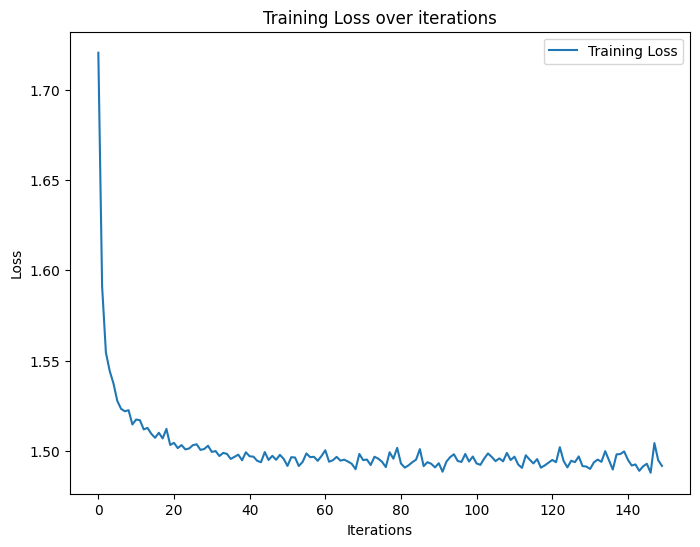

In [12]:
# 可视化损失值
plt.figure(figsize=(8, 6))
plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss over iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()